In [ ]:
%reset -f

In [1]:
import pandas as pd
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

The functions below will only help us reconstruct the images from pystan sampling/fitting results

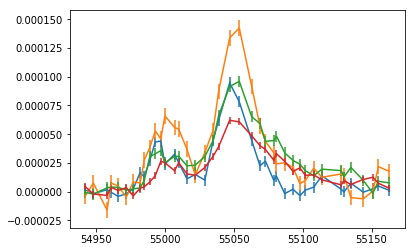

[0.9  2.01] [ 0.     50.0321]
mu2/mu1 = 2.233333333333333
delta_td = 50.0321


In [2]:
import LCSimulator as Alex

In [3]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

In [4]:
# Function for changing the tp spacing for 15 points
def tp_new09(NP,t_min,t_max,dt_min,dt_max):
    intv = ((t_max+dt_max)-t_min)/NP-1
    steps = int(round(NP/4)) # 25% points
    x0 = t_min
    x_end = (t_max+dt_max)
    x_0_eps = np.linspace(x0,x0+steps*intv,2)# first 4 points reduced with 2 pts
    x_end_eps = np.linspace(x_end-steps*intv,x_end,2) # same, Last 4 points
    x_mid = np.linspace(x0+(steps+1)*intv,x_end-(steps+1)*intv,NP-4)
    xt = np.concatenate((x_0_eps,x_mid,x_end_eps))
    return xt     

In [5]:
df = pd.read_hdf('ztf-1a.h5', 'stacked')

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
A_Flux=Alex.flux()
A_time=Alex.time()
A_Fl_er=Alex.flerror()
mu=Alex.mu()
dt=Alex.td()

In [7]:
#sysn=37755722
#datapath="./"
#fin=datapath+'/ztf-1a.h5'
#dfI=pd.read_hdf(fin, 'image')
#print(dfI[dfI['sysno']==sysn]);
mus=mu; dts=dt
mu_expec=np.abs(mus[0]/mus[1]); dt_expec=dts[1]-dts[0]

print("Expected: mu=",mu_expec, "dt=",dt_expec)

Expected: mu= 0.4477611940298508 dt= 50.0321


In [ ]:
#DONT NEED NOW
sysn=37755722
#i=0
#test=pd.DataFrame(list(set(df['sysno'])),columns=['system_no'])[0]
#test[i][0]=sysn
tt=(df[(df['sysno'] == sysn)])

In [ ]:
#DONT NEED NOW
tr=tt[tt['filter']=='ztfr']['time']
tg=tt[tt['filter']=='ztfg']['time']
ti=tt[tt['filter']=='ztfi']['time']

fr=tt[tt['filter']=='ztfr']['flux']
fg=tt[tt['filter']=='ztfg']['flux']
fi=tt[tt['filter']=='ztfi']['flux']

sigfr=tt[tt['filter']=='ztfr']['fluxerr']
sigfg=tt[tt['filter']=='ztfg']['fluxerr']
sigfi=tt[tt['filter']=='ztfi']['fluxerr']

In [8]:
tr=A_time
tg=A_time
ti=A_time

fr=A_Flux[1]
fg=A_Flux[0]
fi=A_Flux[2]

sigfr=A_Fl_er[1]
sigfg=A_Fl_er[0]
sigfi=A_Fl_er[2]

<ErrorbarContainer object of 3 artists>

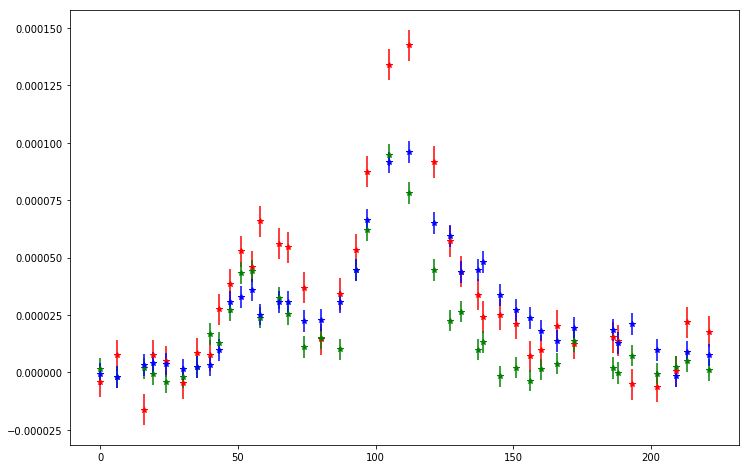

In [9]:
t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

t_max=t_max-t_min; t_min=0.0;

c=['r','g','b']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))

In [25]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        #we add a small number to the diagonal elements of the cov matrix for stability in cholesky decomposition
        for (i in 1:NP){
            K[i,i]=K[i,i]+1e-12;
        }
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=30.0> lr;
    real<lower=5.0, upper=30.0> lg;
    real<lower=5.0, upper=30.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0.0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""

In [11]:
def contour(fit):
    print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"])
    #return fig

In [12]:
def rec(fit,pnr,png,pni):
    plt.rcParams['figure.figsize'] = [18,4 ]
       
    print('Stage 1')
    tpr=tp_new09(pnr,t_min,t_max,dt_min,dt_max)
    tpg=tp_new09(png,t_min,t_max,dt_min,dt_max)
    tpi=tp_new09(pni,t_min,t_max,dt_min,dt_max)
    #print(np.shape(tpr))
    print('Stage 2')
    pp1=fit.get_posterior_mean()
    pos_mean=np.mean(pp1,axis=1)
    print('Stage 3')

    Pr_mean=pos_mean[np.arange(0,pnr)]; 
    Pg_mean=pos_mean[np.arange(pnr,pnr+png)];
    Pi_mean=pos_mean[np.arange(pnr+png,pnr+png+pni)];
    
    print(len(pos_mean),len(Pr_mean),len(Pg_mean),len(Pi_mean))

    lrm=pos_mean[-6]; lgm=pos_mean[-5];lim=pos_mean[-4];

    mum=pos_mean[-3]; dtm=pos_mean[-2]; print("Mean of posterior: mu=",mum,"dt=",dtm,"\n")
    rec.m_pos=mum
    rec.dt_pos=dtm
    print('Stage 4')
    if(pnr==pni):
        print("P's are calculated at t= ",tpr)
    print('Stage 5')

    Ps1r=get_GP_mean(tpr,Pr_mean,tr,lrm)
    Ps2r=mum*get_GP_mean(tpr,Pr_mean,tr+dtm,lrm)
    rconst_signal_r=Ps1r+Ps2r#+Ps3+Ps4;
    Psr=Ps1r+Ps2r


    Ps1g=get_GP_mean(tpg,Pg_mean,tg,lgm)
    Ps2g=mum*get_GP_mean(tpg,Pg_mean,tg+dtm,lgm)
    rconst_signal_g=Ps1g+Ps2g#+Ps3+Ps4;
    Psg=Ps1g+Ps2g

    Ps1i=get_GP_mean(tpi,Pi_mean,ti,lim)
    Ps2i=mum*get_GP_mean(tpi,Pi_mean,ti+dtm,lim)
    rconst_signal_i=Ps1i+Ps2i#+Ps3+Ps4;
    Psi=Ps1i+Ps2i

    chisq_r=np.sum((Psr-fr)**2/sigfr**2); 
    chisq_g=np.sum((Psg-fg)**2/sigfg**2); 
    chisq_i=np.sum((Psi-fi)**2/sigfi**2);
    print('Parameter ',np.shape(Pr_mean))
    print("\n Reduced Chi^2-->r-band ",np.sum((Psr[7:35]-fr[7:35])**2/sigfr[7:35]**2) )
    #print("\n Psr, fr, sigfr",np.shape(Psr),np.shape(fr),np.shape(sigfr))
    print("\n \nchi^2--> r-band=",chisq_r, ", g-band=",chisq_g, ", i-band=", chisq_i)
    print("data points in r-band=",len(tr), ", g-band=",len(tg), ", i-band=",len(ti))
    plt.subplot(1, 3, 1)
    #plt.ylim(0,1)
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]), label=r"r-band data")
    plt.plot(tr,Psr, c=c[0], label=r"combined reconstruction with mean" )
    plt.plot(tr,Ps1r, ls="dotted", c=c[0], label=r"pystan image 1")
    plt.plot(tr,Ps2r, ls="dashdot", c=c[0], label=r"pystan image 2")
    plt.scatter(tpr, Pr_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    

    plt.subplot(1, 3, 2)
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]), label=r"g-band data")
    plt.plot(tg,Psg, c=c[1], label=r"combined reconstruction")
    plt.plot(tg,Ps1g, ls="dotted", c=c[1], label=r"pystan image 1")
    plt.plot(tg,Ps2g, ls="dashdot", c=c[1], label=r"pystan image 2")
    plt.scatter(tpg, Pg_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]), label=r"i-band data")
    plt.plot(ti,Psi, c=c[2], label=r"combined reconstruction")
    plt.plot(ti,Ps1i, ls="dotted", c=c[2], label=r"pystan image 1")
    plt.plot(ti,Ps2i, ls="dashdot", c=c[2], label=r"pystan image 2")
    plt.scatter(tpi, Pi_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    plt.show()

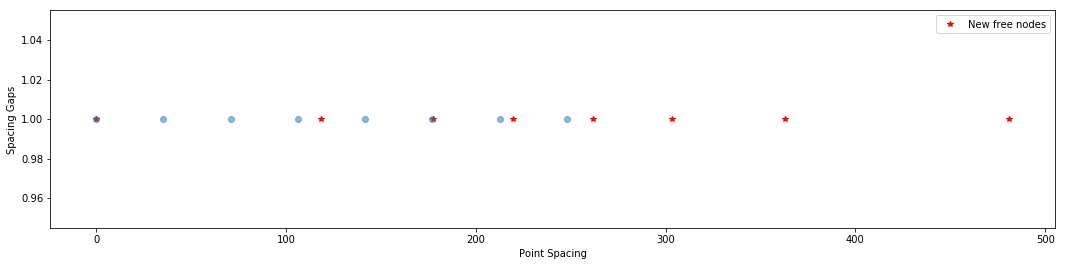

In [136]:
y= np.ones(NP)
plt.plot(tp,y,'*',label='New free nodes',c='r')
plt.plot(np.linspace(t_min, t_max+dt_max, NP),y,'o',alpha=0.5)
plt.xlabel('Point Spacing')
plt.ylabel('Spacing Gaps')
plt.legend()

### USED :The cells below 

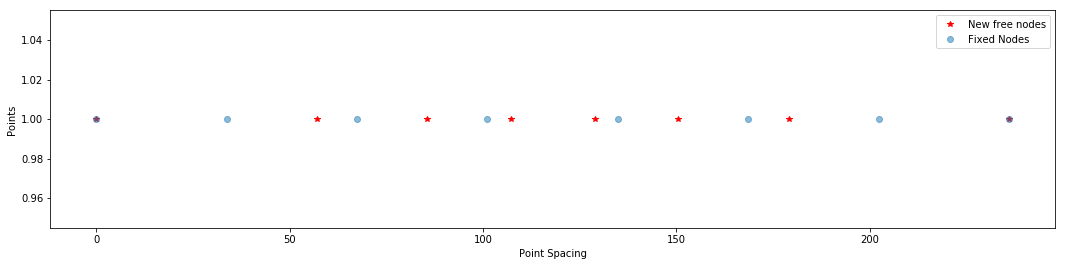

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cee9e164bd0cdfc8aa1e9196aa1d7fa0 NOW.


tp= [  0.          57.000005    85.5000075  107.16667583 128.83334417
 150.5000125  179.000015   236.00002   ]
td= 33.71428857142954


Inference for Stan model: anon_model_cee9e164bd0cdfc8aa1e9196aa1d7fa0.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1] 2.9e-6  2.8e-8 2.2e-6 9.7e-8 1.1e-6 2.4e-6 4.1e-6 8.3e-6   6107    1.0
Pr[2] 4.8e-5  6.4e-8 3.1e-6 4.2e-5 4.6e-5 4.9e-5 5.1e-5 5.4e-5   2325    1.0
Pr[3] 2.1e-5  5.9e-8 3.3e-6 1.5e-5 1.9e-5 2.1e-5 2.3e-5 2.7e-5   3041    1.0
Pr[4] 1.1e-4  1.4e-7 5.2e-6 9.8e-5 1.1e-4 1.1e-4 1.1e-4 1.2e-4   1353   1.01
Pr[5] 4.2e-5  6.0e-8 3.3e-6 3.5e-5 3.9e-5 4.2e-5 4.4e-5 4.8e-5   2936    1.0
Pr[6] 1.3e-5  7.3e-8 3.0e-6 6.7e-6 1.1e-5 1.3e-5 1.5e-5 1.9e-5   1702    1.0
Pr[7] 1.2e-5  5.4e-8 3.6e-6 5.5e-6 9.9e-6 1.2e-5 1.5e-5 2.0e-5   4429    1.0
Pr[8] 4.3e-5  1.8e-7 1.4e-5 1.7e-5 3.3e-5 4.2e-5 5.2e-5 7.3e-5   5829    1.0
Pg[1] 2.2e-6  2.1e-8 1.6e-6 8.3e-8 8.8e-7 1.9e-6 3.2e-6 6.0e-6   5813    1.0
Pg[2] 3.1e-5  4.0e-8 2.2e-6 2.7e-5 3.0e-5 

In [26]:
NI=2
NP=8;
dt_min=0.0; dt_max=15.0

tp_fixed=np.linspace(t_min, t_max+dt_max, NP)
#tp=tp_new08(NP,t_min,t_max+dt_max)

intv = ((t_max+dt_max)-t_min)/NP-1
steps = int(round(NP/4)) # 25% points
x0 = t_min
x_end = (t_max+dt_max)
x_0_eps = np.linspace(x0,x0+steps*intv,2)# first 4 points reduced with 2 pts
x_end_eps = np.linspace(x_end-steps*intv,x_end,2) # same, Last 4 points
x_mid = np.linspace(x0+(steps+1)*intv,x_end-(steps+1)*intv,NP-4)
tp = np.concatenate((x_0_eps,x_mid,x_end_eps))
    


y= np.ones(NP)
plt.plot(tp,y,'*',label='New free nodes',c='r')
plt.plot(tp_fixed,y,'o',alpha=0.5,label='Fixed Nodes')
plt.xlabel('Point Spacing')
plt.ylabel('Points')
plt.legend()
plt.show()

print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);

data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit0 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit0)

Expected: mu= 0.4477611940298508 dt= 50.0321


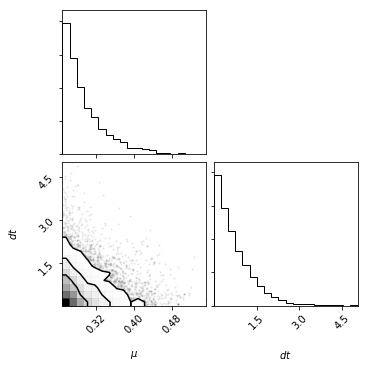

In [27]:
contour(fit0)

Stage 1
Stage 2
Stage 3
30 8 8 8
Mean of posterior: mu= 0.29717578354094154 dt= 0.7190380062714276 

Stage 4
P's are calculated at t=  [  0.          57.000005    85.5000075  107.16667583 128.83334417
 150.5000125  179.000015   236.00002   ]
Stage 5
Parameter  (8,)

 Reduced Chi^2-->r-band  31.363554443583794

 
chi^2--> r-band= 52.77331580514873 , g-band= 44.08500442222471 , i-band= 37.7165903416184
data points in r-band= 40 , g-band= 40 , i-band= 40


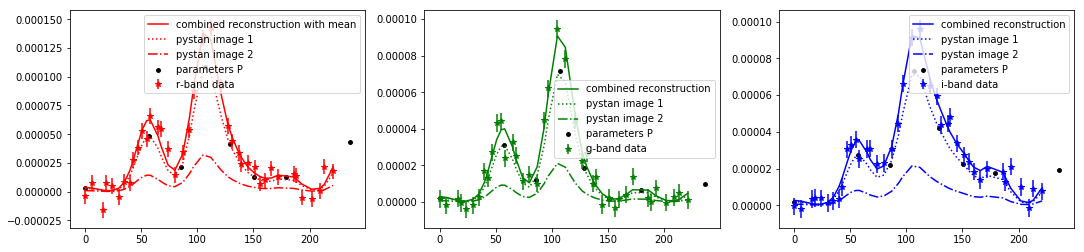

In [28]:
rec(fit0, 8,8,8)#free node function in model input

Stage 1
Stage 2
Stage 3
51 15 15 15
Mean of posterior: mu= 0.2781036353885538 dt= 8.249309977325256 

Stage 4
P's are calculated at t=  [  0.          62.13333867  77.66667333  86.93334067  96.200008
 105.46667533 114.73334267 124.00001    133.26667733 142.53334467
 151.800012   161.06667933 170.33334667 185.86668133 248.00002   ]
Stage 5
Parameter  (15,)

 Reduced Chi^2-->r-band  6319441.069272504

 
chi^2--> r-band= 173427888501.22275 , g-band= 6956686.052789097 , i-band= 112770315467.87271
data points in r-band= 40 , g-band= 40 , i-band= 40


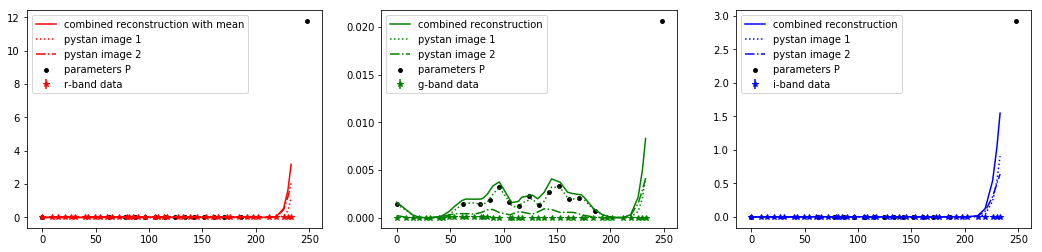

In [178]:
rec(fit0, 15,15,15)#free node function in model input

### The result below is from a previous realization of Alex's data, where the delta td ~ 14 days and mu1/mu2 ~ 0.44. The corresponding original flux plot is not shown here, but for record the fits are still kept to have a look. 

Stage 1
Stage 2
Stage 3
30 8 8 8
Mean of posterior: mu= 0.2958084455208894 dt= 0.3320070887437762 

Stage 4
P's are calculated at t=  [  0.          60.000005    90.0000075  112.66667583 135.33334417
 158.0000125  188.000015   248.00002   ]
Stage 5
Parameter  (8,)

 Reduced Chi^2-->r-band  125.56817963183617

 
chi^2--> r-band= 163.55449463559756 , g-band= 77.59625199107383 , i-band= 166.75823780791694
data points in r-band= 40 , g-band= 40 , i-band= 40


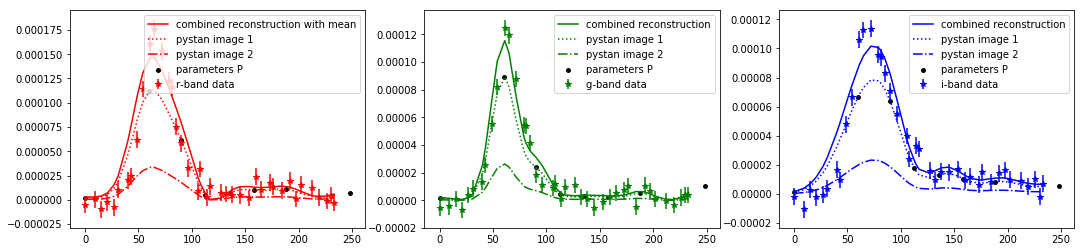

In [158]:
rec(fit0, 8,8,8)#free node function in model input

### NP =15. Not used 

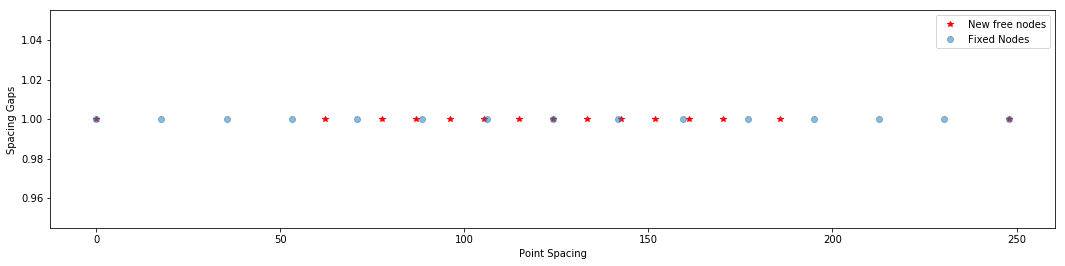

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c311571e3884dc0539471611f2ee76f NOW.


tp= [  0.          62.13333867  77.66667333  86.93334067  96.200008
 105.46667533 114.73334267 124.00001    133.26667733 142.53334467
 151.800012   161.06667933 170.33334667 185.86668133 248.00002   ]


Inference for Stan model: anon_model_8c311571e3884dc0539471611f2ee76f.
6 chains, each with iter=4000; warmup=400; thin=3; 
post-warmup draws per chain=1200, total post-warmup draws=7200.

         mean se_mean      sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]  2.3e-3  2.5e-3    0.01  2.2e-7 2.5e-6 6.1e-6 4.0e-4   0.02     19   1.24
Pr[2]  2.4e-3  2.5e-3    0.01  1.2e-4 1.3e-4 1.4e-4 3.2e-4   0.02     20   1.23
Pr[3]  1.6e-3  1.6e-3  6.8e-3  1.1e-4 1.2e-4 1.2e-4 3.4e-4   0.01     18   1.26
Pr[4]  4.6e-3  5.3e-3    0.02  4.8e-5 5.9e-5 6.6e-5 2.0e-4   0.04     21   1.21
Pr[5]  4.9e-3  5.5e-3    0.02  1.5e-5 2.7e-5 3.6e-5 3.6e-4   0.04     20   1.22
Pr[6]  2.8e-3  3.1e-3    0.01  5.3e-6 1.5e-5 2.2e-5 3.8e-4   0.02     21   1.21
Pr[7]  3.6e-3  4.1e-3    0.02  1.2e-6 7.1e-6 1.3e-5 1.5e-4   0.03     20   1.22
Pr[8]  1.9e-3  1.6e-3  7.6e-3  5.4e-7 6.5e-6 1.4e-5 1.4e-3   0.02     21   1.21
Pr[9]  5.3e-3  5.9e-3    0.03  4.1e-7 4.4e-6 1.0e-5 5.4e-4   0.05     20   1.21
Pr[10] 2.9e-

In [175]:
NI=2
NP=15
dt_min=0.0; dt_max=15.0

tp_fixed=np.linspace(t_min, t_max+dt_max, NP)
#tp=tp_new08(NP,t_min,t_max+dt_max)

intv = ((t_max+dt_max)-t_min)/NP-1
steps = int(round(NP/4)) # 25% points
x0 = t_min
x_end = (t_max+dt_max)
x_0_eps = np.linspace(x0,x0+steps*intv,2)# first 4 points reduced with 2 pts
x_end_eps = np.linspace(x_end-steps*intv,x_end,2) # same, Last 4 points
x_mid = np.linspace(x0+(steps+1)*intv,x_end-(steps+1)*intv,NP-4)
tp = np.concatenate((x_0_eps,x_mid,x_end_eps))
    


y= np.ones(NP)
plt.plot(tp,y,'*',label='New free nodes',c='r')
plt.plot(tp_fixed,y,'o',alpha=0.5,label='Fixed Nodes')
plt.xlabel('Point Spacing')
plt.ylabel('Spacing Gaps')
plt.legend()
plt.show()

print("tp=",tp)
#td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);

data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}
sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=4000, chains=6, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

In [168]:
contour(fit3)

In [167]:
npn=15
rec(fit3, npn,npn,npn)